In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
import scipy
import random
import argparse

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import Resnet_multiscale_general as net

In [2]:
#===========================================================================================================
def find_ave_random_paths(t_list_list, mse_list):
    to_ave = np.zeros((num_lines, 10000, test_data.shape[-1]))
    i = 0 
    j = 4
    print(t_list_list[i][j])
    for i in range(num_lines):
        for j in range(len(t_list_list[i])):
            to_ave[i, int(t_list_list[i][j])] = mse_list[i][j]

    averages = np.zeros(10000)
    to_ave[to_ave == 0] = np.nan
    means = np.nanmean(to_ave[:, 1:], axis=0)
    stds = np.nanstd(to_ave[:, 1:], axis=0)
    percent_95 = np.nanpercentile(to_ave[:, 1:], 95, axis = 0)
    percent_5 = np.nanpercentile(to_ave[:, 1:], 5, axis = 0)

    mask = np.isfinite(means[:,0])
    ts = np.arange(1, 10000)

    return ts[mask], means[mask], stds[mask], percent_95[mask], percent_5[mask]
   
#===========================================================================================================

def predict_random_combo(model_depends, models_original, test_data, timesteps = 5000, to_plot=True):
    t = 0
    n_test_points, _, ndim = test_data.shape


    t_list = list()
    y_pred_list_depends = list()
    y_pred_list_original = list()

    indices = np.random.randint(0,len(step_sizes), int(timesteps/min(step_sizes)))
    steps = list()
    for i in range(len(indices)):
        steps.append(step_sizes[indices[i]])
        if sum(steps)>timesteps:
            break
    
    y_pred_list_depends = np.zeros((n_test_points, len(steps)-1, ndim))
    y_pred_list_original = np.zeros((n_test_points, len(steps)-1, ndim))
    y_preds_depends = torch.tensor(test_data[:, 0]).float()
    y_preds_original = torch.tensor(test_data[:, 0]).float()

    for i in range(len(steps)-1):
        this_pick = indices[i]
        this_step_size = steps[i]
        t+= this_step_size
        y_preds_depends = model_depends.forward(y_preds_depends, str(this_step_size))
        y_preds_original = models_original[this_pick].forward(y_preds_original)

        y_pred_list_depends[:,i] = y_preds_depends.detach().numpy()
        y_pred_list_original[:,i] = y_preds_original.detach().numpy()
        t_list.append(t)
        
    t_list = np.array(t_list)
    y_pred_list_depends = np.array(y_pred_list_depends)
    y_pred_list_original = np.array(y_pred_list_original)
    
    
    mse_depends = np.mean((y_pred_list_depends - test_data[:,t_list.astype(int)])**2, axis = (0,2))
    mse_original = np.mean((y_pred_list_original - test_data[:,t_list.astype(int)])**2, axis = (0,2))
    
    return y_pred_list_depends, y_pred_list_original, mse_depends, mse_original, t_list
#===========================================================================================================

In [25]:
data_system = 'hyperbolic'

system = 'hyperbolic800'
noise = 0.1
smallest_step = 8
step_sizes = [8, 16, 32]
dt = 0.01

letter = 'c'
noise_list = [0.0, 0.05,0.2,  0.8]

# paths
data_dir = os.path.join('../../data/', data_system)
model_dir = os.path.join('../../models/', system)
    

In [26]:
t_list_list_all = list()
mse_list_depends_all = list()
mse_list_original_all = list()

for noise in noise_list:
    
    try:
        file_base = 'model_{}_depends_stepsize{}_noise{}_{}'.format(system, smallest_step, noise, letter)

        t_list_list = np.load(os.path.join(model_dir, file_base + "_time.npy"), allow_pickle=True)
        mse_list_depends = np.load(os.path.join(model_dir, file_base + "_depends.npy"), allow_pickle=True)
        mse_list_original = np.load(os.path.join(model_dir, file_base + "_original.npy"), allow_pickle=True)

    except:
        test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))


        n_test_points, _, ndim = test_data.shape

        n_test = test_data.shape[0]

        print("test_data.shape = ", test_data.shape)


        #load depend model
        model_name = 'model_{}_depends_stepsize{}_noise{}_{}.pt'.format(system, smallest_step, noise, letter)
        model_depends = torch.load(os.path.join(model_dir, model_name), map_location='cpu')
        model_depends.device = 'cpu'

        print("model_depends.step_sizes= ", model_depends.step_sizes)
        for step_size in model_depends.step_sizes:
            model_depends._modules[str(step_size)]._modules['activation'] = torch.nn.ReLU()


        #load original models
        # load models
        models_original = list()
        for step_size in model_depends.step_sizes:
            model_name = 'original_model_D{}_noise{}.pt'.format(step_size, noise, letter)
            print("load ", model_name)
            try:
                try:
                    models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
                except:
                    try:
                        model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, letter)
                        models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
                    except:
                        model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, 'b')
                        models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
            except:
                print("done loading at {}".format(step_size))
                break


        to_plot = False
        timesteps = test_data.shape[1] - 1
        #less for Lorenz
        if "Lorenz" in system:
            timesteps = 1000

        elif "KS" in system:
            timesteps = 1000

        print("timesteps = ", timesteps)


        num_lines = 500
        mse_list_depends = list()
        mse_list_original = list()
        t_list_list = list()
        path_list = list()
        y_pred_list_depends = list()
        y_pred_list_original = list()


        #train all the random lines of both models
        for i in range(num_lines):
            print("i = ", i)

            y_preds_random_depends, y_preds_random_original, mse_random_depends, mse_random_original, t_list_random = predict_random_combo(model_depends, models_original, test_data, timesteps = timesteps, to_plot=False)
            y_pred_list_depends.append(y_preds_random_depends[0,:])
            y_pred_list_original.append(y_preds_random_original[0,:])
            mse_list_depends.append(mse_random_depends)
            mse_list_original.append(mse_random_original)
            t_list_list.append(t_list_random)



        file_base = 'model_{}_depends_stepsize{}_noise{}_{}'.format(system, smallest_step, noise, letter)

        np.save(os.path.join(model_dir, file_base + "_time.npy"), np.array(t_list_list, dtype=object))
        np.save(os.path.join(model_dir, file_base + "_depends.npy"), np.array(mse_list_depends, dtype=object))
        np.save(os.path.join(model_dir, file_base + "_original.npy"), np.array(mse_list_original, dtype=object))

    t_list_list_all.append(t_list_list)
    mse_list_depends_all.append(mse_list_depends)
    mse_list_original_all.append(mse_list_original)
    

In [13]:
file_base = 'model_{}_depends_stepsize{}_noise{}_{}'.format(system, smallest_step, noise, letter)

np.save(os.path.join(model_dir, file_base + "_time.npy"), np.array(t_list_list_all, dtype=object))
np.save(os.path.join(model_dir, file_base + "_depends.npy"), np.array(mse_list_depends_all, dtype=object))
np.save(os.path.join(model_dir, file_base + "_original.npy"), np.array(mse_list_original_all, dtype=object))


112


/tmp/ipykernel_759/4023873419.py:13: RuntimeWarning: Mean of empty slice
  means = np.nanmean(to_ave[:, 1:], axis=0)


112
112
112
104
104
112
112
96
96
80
80


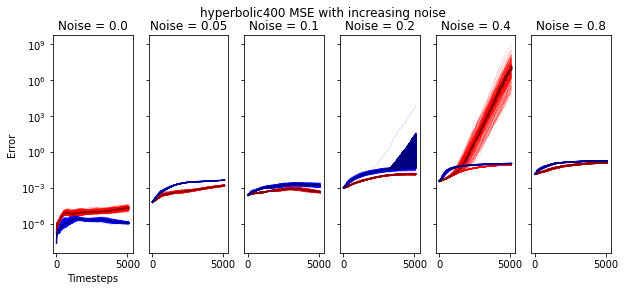

In [20]:

#start of the plotting code

fig, axs  = plt.subplots(1, len(noise_list), sharey='row', figsize=(10, 4))

for idx_noise in range(len(noise_list)):
    noise = noise_list[idx_noise]
    
    t_list_list = t_list_list_all[idx_noise]
    mse_list_depends = mse_list_depends_all[idx_noise]
    mse_list_original = mse_list_original_all[idx_noise]
        #find the average paths for both methods
    ts_depends, means_depends, stds_depends, _, _ = find_ave_random_paths(t_list_list, mse_list_depends)
    ts_original, means_original, stds_original, _, _ = find_ave_random_paths(t_list_list, mse_list_original)
    # graph the mse both themods with a random line for each trial and thicker line for average of mse
#     plt.figure()
    for i in range(len(mse_list_depends)):
        axs[idx_noise].semilogy(t_list_list[i], mse_list_depends[i], 'r', linewidth = 0.25, alpha = 0.5)
        axs[idx_noise].semilogy(t_list_list[i], mse_list_original[i], 'b', linewidth = 0.25, alpha=0.5)

    axs[idx_noise].semilogy(ts_depends, means_depends[:,0], color='darkred', label="depends")
    axs[idx_noise].semilogy(ts_original, means_original[:,0], color='navy', label="original")
#     plt.legend()
    axs[idx_noise].set_title("Noise = " + str(noise))
#     plt.title(system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths :step_sizes = "+str(step_sizes))
    # plt.savefig("{}_{}_min{}_MSE_both_n{}_all.jpg".format(system, letter, min(step_sizes), noise))

#     plt.ylim([min_lim, max_lim*10])

axs[0].set(xlabel='Timesteps', ylabel='Error')
fig.suptitle(system + ' MSE with increasing noise')#system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths :step_sizes = "+str(step_sizes))


plt.show()


In [ ]:
ts, means, stds, percent_95, percent_5 = find_ave_random_paths(t_list_list, mse_list_depends)

In [ ]:
plt.plot(ts, percent_95)
plt.plot(ts, percent_5)
print(percent_95)

72


/tmp/ipykernel_759/4023873419.py:13: RuntimeWarning: Mean of empty slice
  means = np.nanmean(to_ave[:, 1:], axis=0)


72
128
128
144
144
96
96


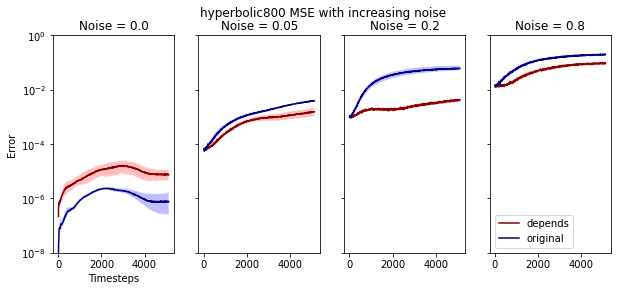

In [27]:

#start of the plotting code

fig, axs  = plt.subplots(1, len(noise_list), sharey='row', figsize=(10, 4))

for idx_noise in range(len(noise_list)):
    noise = noise_list[idx_noise]
    
    t_list_list = t_list_list_all[idx_noise]
    mse_list_depends = mse_list_depends_all[idx_noise]
    mse_list_original = mse_list_original_all[idx_noise]
        #find the average paths for both methods
    ts_depends, means_depends, stds_depends, percent_95_depends, percent_5_depends = find_ave_random_paths(t_list_list, mse_list_depends)
    ts_original, means_original, stds_original, percent_95_original, percent_5_original = find_ave_random_paths(t_list_list, mse_list_original)

    

    axs[idx_noise].semilogy(ts_depends, means_depends[:,0], color='darkred', label="depends")
    axs[idx_noise].semilogy(ts_original, means_original[:,0], color='navy', label="original")
    
#     for n_stds in [1, 2, 3]:
#         axs[idx_noise].fill_between(ts_depends, means_depends[:,0]+n_stds*stds_depends[:,0], means_depends[:,0]-n_stds*stds_depends[:,0], facecolor='red', alpha=0.25)
#         axs[idx_noise].fill_between(ts_original, means_original[:,0]+n_stds*stds_original[:,0], means_original[:,0]-n_stds*stds_original[:,0], facecolor='blue', alpha=0.25)

    axs[idx_noise].fill_between(ts_depends, percent_5_depends[:,0], percent_95_depends[:,0], facecolor='red', alpha=0.25)
    axs[idx_noise].fill_between(ts_original, percent_5_original[:,0], percent_95_original[:,0], facecolor='blue', alpha=0.25)


#     plt.legend()
    axs[idx_noise].set_title("Noise = " + str(noise))
    

#     plt.ylim([min_lim, max_lim*10])

axs[0].set(xlabel='Timesteps', ylabel='Error')
axs[len(noise_list)-1].legend()
fig.suptitle(system + ' MSE with increasing noise')#system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths :step_sizes = "+str(step_sizes))

plt.ylim([1e-8, 1])
plt.show()


In [ ]:
 # graph the mse both themods with a random line for each trial and thicker line for average of mse
plt.figure()
plt.semilogy(ts_depends, means_depends[:,0], color='darkred', label="depends")
plt.semilogy(ts_original, means_original[:,0], color='navy', label="original")



plt.legend()
plt.title(system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths :step_sizes = "+str(step_sizes))
plt.savefig("{}_{}_min{}_MSE_both_n{}_all.jpg".format(system, letter, min(step_sizes), noise))

In [ ]:

n_timesteps = 1e10
for i in range(len(t_list_list)):
    if n_timesteps > max(t_list_list[i]):
        n_timesteps = max(t_list_list[i])
        
y_preds_all_depends = np.zeros((len(y_pred_list_depends), n_timesteps, test_data.shape[2]))
y_preds_all_original = np.zeros((len(y_pred_list_original), n_timesteps, test_data.shape[2]))
#we need to interpolate y_preds
for i in range(len(t_list_list)):
    t = np.insert(t_list_list[i], 0, 0)
    y_depends = np.insert(y_pred_list_depends[i], 0, test_data[0,0], axis = 0)
    y_original = np.insert(y_pred_list_original[i], 0, test_data[0,0], axis = 0)
    
    sample_steps = range(0, n_timesteps)
    cs_depends = scipy.interpolate.interp1d(t, y_depends.T, kind='linear')
    y_preds_depends = cs_depends(sample_steps).T
    y_preds_all_depends[i] = y_preds_depends
    
    cs_original = scipy.interpolate.interp1d(t, y_original.T, kind='linear')
    y_preds_original = cs_original(sample_steps).T
    y_preds_all_original[i] = y_preds_original


means_depends = np.mean(y_preds_all_depends, axis = 0)
stds_depends = np.std(y_preds_all_depends, axis = 0)

means_original = np.mean(y_preds_all_original, axis = 0)
stds_original = np.std(y_preds_all_original, axis = 0)

ts = sample_steps



plt.figure()
plt.plot(test_data[0,:timesteps], 'g', label = 'test_data', linewidth = 0.5)
plt.plot(ts, means_depends, 'r', label = "depends")
plt.plot(ts, means_original, 'blue', label = "original")
for i in range(len(means_depends[0])):
    for n_stds in range(1, 4):
        plt.fill_between(ts, means_depends[:,i]+n_stds*stds_depends[:,i], means_depends[:,i]-n_stds*stds_depends[:,i], facecolor='red', alpha=0.25)
        plt.fill_between(ts, means_original[:,i]+n_stds*stds_original[:,i], means_original[:,i]-n_stds*stds_original[:,i], facecolor='blue', alpha=0.25)
        
plt.legend()
plt.title(system + ": Predicted 1 path: noise = " + str(noise) +" :step_sizes = "+str(step_sizes))
plt.savefig("{}_{}_min{}_both_predict_first_shaded_n{}.jpg".format(system, letter, min(step_sizes), noise))